<a href="https://colab.research.google.com/github/tauseef1234/Spam_Labeling_Snorkel/blob/main/SMS_Snorkel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Snorkel - Data labeling using weak supervision on SMS Spam Collection Data Set

-----

## Brief introduction to Snorkel

Creating labelled training sets is an expensive and time consuming task for building a machine learning model. The traditional approach to perform this task is to hire a team that would label the data manually.

Snorkel provides a framework to programtically label, build and manage training data with [*weak supervision*](https://www.snorkel.org/blog/weak-supervision). Below image shows Snorkel's architecture which consists of three main stages:

1. Writing labeling functions (LFs): Labeling function provides an abstracted way to express various heuristic or noisy programmatic labeling strategies. by employing different kinds of weak supervision sources: patterns, heuristics, external knowledge bases, crowdsourced labels, etc.

2. Modeling accuracies and correlations: Snorkel creates a generative model based on labeling functions’ correlations, that is, where they agree or disagree.

3. Training a discriminative model: While the output is probabilistic labels, the ultimate goal is to train a discriminative model (such as popular ML models) that will be able to generalize beyond the noisy generative model.

<img src = 'https://miro.medium.com/max/2000/1*2vim0mfyVRCH_f9cZ90iag.png'>

## Objective

The objective of this ML project is to train a classifier over text data that can predict whether a text message is spam or not spam. The dataset used for this project has been collected from [papers with code](https://paperswithcode.com/) website. More details about source of the dataset can be found [here](https://paperswithcode.com/dataset/sms-spam-collection-data-set).


**Install snorkel**

In [ ]:
!pip install snorkel==0.9.7

**Import Packages**

In [ ]:
# import packages
import pandas as pd
import numpy as np
import re



## Read the dataset

In [ ]:
#read spam dataset
df_sms = pd.read_csv('https://raw.githubusercontent.com/tauseef1234/Datasets/main/spam.csv',encoding='ISO-8859-1')
df_sms.info()
df_sms.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Some of the messages in the raw file is spread across multiple columns. We append all the text in a single column and then drop the remaining columns.

In [ ]:
# replacing nan with blank space
cols =['Unnamed: 2','Unnamed: 3','Unnamed: 4']
for col in cols:
  df_sms[col].replace(np.nan,'',regex=True, inplace=True)

In [ ]:
# concatnating all columns
df_sms['v2']=df_sms['v2'] + df_sms['Unnamed: 2'].astype(str) + df_sms['Unnamed: 3'].astype(str) + df_sms['Unnamed: 4'].astype(str)

In [ ]:
# drop the unnamed columns
df_sms.drop(columns=cols,inplace=True)

**Prepare the train and test dataset**

In [ ]:
# rename fields
df_sms = df_sms.rename(columns={"v1": "label", "v2": "text"})
# shuffle order
df_sms = df_sms.sample(frac=1, random_state=123).reset_index(drop=True)

# split the data into train and test datasets
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(
        df_sms, test_size=0.2, random_state=123, stratify=df_sms.label
    )

In [ ]:
# display train and test data
print("Train")
display(df_train.head())
print('Test')
df_test.head()

Train


,label,text
4114,ham,Double eviction this week - Spiral and Michael...
179,spam,This is the 2nd time we have tried 2 contact u...
2332,ham,3 pa but not selected.
3549,ham,Okie
3240,ham,Anything is valuable in only 2 situations: Fir...


Test


,label,text
4565,ham,Alrite jod hows the revision goin? Keris bin d...
2831,ham,When can Ì_ come out?
2489,ham,I'm fine. Hope you are good. Do take care.
3865,ham,Mine here like all fr china then so noisy.
3852,ham,Shant disturb u anymore... Jia you...


In [ ]:
# check train and test data dimension
print (df_train.info())
print (df_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4457 entries, 4114 to 3387
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   4457 non-null   object
 1   text    4457 non-null   object
dtypes: object(2)
memory usage: 104.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1115 entries, 4565 to 1929
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   1115 non-null   object
 1   text    1115 non-null   object
dtypes: object(2)
memory usage: 26.1+ KB
None


In [ ]:
df_train['label'].value_counts()

ham     3859
spam     598
Name: label, dtype: int64

In [ ]:
df_test['label'].value_counts()

ham     966
spam    149
Name: label, dtype: int64

In [ ]:
# define constants to represent the class labels for spam, ham and abstain
ABSTAIN = -1
HAM = 0
SPAM = 1

In [ ]:
# map constant values to the labels 'ham' and 'spam' in the dataset
dict_map = {'ham':HAM,'spam':SPAM}
Y_train = df_train['label'].map(dict_map).values
Y_test = df_test['label'].map(dict_map).values

## Write Labeling Functions

**Pattern-matching LFs**

In this step, we write labelling functions using regex pattern matching in order to look for specific syntactical pattern. This is where we will use our "domain knowledge" (or in this case mostly common knowledge as most of us recognize patterns of spam and non-spam messages) to write python programs (LFs) that take as input a data point and assign labels using pattern matching.

Below are some of the LFs defined using regex pattern matching:

1. `smiley_face` - Ham messages are personal which have emoticons included. This LS looks for emoticons
2. `regex_pobox` - Spam messages have addresses with 'PO BOX' details
3. `regex_tc` -   Promotional spam messages have acronym for 'terms and conditions' like T&C, TnC, TC, T C.
4. `spam_numbers` - Spam messages have 5-digit number for texting promotional codes or a 10-digit phone number to call.

5. `regex_punc` - Messages shared by many people including family and friends use multiple full stop at the end of sentences. We classify those messages as non-spam.

In [ ]:
from snorkel.labeling import labeling_function

# Ham messages tend to have personal emoticons
@labeling_function()
def smiley_face(x):
    return HAM if re.search(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)',x.text) else ABSTAIN

# SPAM messages can have post office as text
@labeling_function()
def regex_pobox(x):
    return SPAM if re.search(r"po.*box", x.text, flags=re.I) else ABSTAIN

# SPAM messages have various acronyms for terms and conditions
@labeling_function()
def regex_tc(x):
    return SPAM if re.search(r"T.{0,2}C", x.text) else ABSTAIN

# SPAM messages can have 5-digit text numbers or 10-digit phone numbers
@labeling_function()
def spam_numbers(x):
    return SPAM if re.search(r'\b\d{5}\b|\b\d{10}\b',x.text) else ABSTAIN

# HAM messages can have multiple full stops
@labeling_function()
def regex_punc(x):
    return HAM if re.search(r'\.{3,}',x.text) else ABSTAIN

**Keyowrd LFs**

Next, we define additional labelling functions using keyword searches to look for specific keywords in a sentence.  Similar to the labeling_function decorator, the LabelingFunction class wraps a Python function (the f parameter), and we can use the resources parameter to pass in keyword arguments to the function.

In [ ]:
from snorkel.labeling import LabelingFunction


def keyword_lookup(x, keywords, label):
    if any(word in x.text.lower() for word in keywords):
        return label
    return ABSTAIN

def make_keyword_lf(keywords, label=SPAM):
    return LabelingFunction(
        name=f"keyword_{keywords[0]}",
        f=keyword_lookup,
        resources=dict(keywords=keywords, label=label),
    )

"""Spam messages ask users to subscribe to their webpage or channel"""
keyword_subscribe = make_keyword_lf(keywords=["subscribe"])

"""Spam comments post links to webpage or channels"""
keyword_link = make_keyword_lf(keywords=["http","www"])

"""Spam comments make impersonal requests"""
keyword_please = make_keyword_lf(keywords=["urgent", "private","STOP", "satisfaction", "guaranteed", "FREE"])

"""Spam comments with calletunes and voicemail"""
keyword_song = make_keyword_lf(keywords=["callertunes","voicemail"])

"""Spam comments actually talk about win and award"""
keyword_win = make_keyword_lf(keywords=["reward", "points", "voucher", "bonus", "code", "gift", "claim", "prize", "expires", "award"])

"""HAM comments have personal references of family and friends"""
keyword_personal =make_keyword_lf(keywords=['bro','mum','papa', 'dad','daddy','mom','mommy', 'father', 'mother'],label=HAM)

"""HAM comments getting delivered via a third party website source"""
keyword_fullonsms =make_keyword_lf(keywords=['fullonsms.com'],label=HAM)

**Heuristic LFs**

Rule based labeling functions using heuristics after going through the data.

In [ ]:
@labeling_function()
def short_comment(x):
    """Ham comments are often short, such as 'cool video!'"""
    return HAM if len(x.text.split()) < 5 else ABSTAIN

**LFs that use third-party models**

Next, we creat a Preprocessor that runs `TextBlob` (a python NLP library) on our text messages, then extracts the polarity and subjectivity scores. Here, we will focus on writing LFs for HAM, since we identified SPAM comments in above LFs.

In [ ]:
from snorkel.preprocess import preprocessor
from textblob import TextBlob
@preprocessor(memoize=True)
def textblob_sentiment(x):
    scores = TextBlob(x.text)
    x.polarity = scores.sentiment.polarity
    x.subjectivity = scores.sentiment.subjectivity
    return x 

@labeling_function(pre=[textblob_sentiment])
def textblob_polarity(x):
    return HAM if x.polarity > 0.9 else ABSTAIN

@labeling_function(pre=[textblob_sentiment])
def textblob_subjectivity(x):
    return HAM if x.subjectivity >= 0.5 else ABSTAIN

**LFs with Complex Preprocessor**

Here we use the NLP library `spaCy` that can be used to add lemmas, part-of-speech (pos) tags, etc. to each token. Snokel has a prebuilt spaCy preprocessor called `SpacyPreprocessor` which adds a new field to the data point containing a spaCy Doc object.

In [ ]:
from snorkel.preprocess.nlp import SpacyPreprocessor

spacy = SpacyPreprocessor(text_field="text", doc_field="doc", memoize=True)


@labeling_function(pre=[spacy])
def has_person(x):
    """Ham comments mention specific people and are short."""
    if len(x.doc) < 20 and any([ent.label_ in ["PERSON","GPE"] for ent in x.doc.ents]):
        return HAM
    else:
        return ABSTAIN

In [ ]:
from snorkel.labeling.lf.nlp import nlp_labeling_function
@nlp_labeling_function()
def has_person_nlp(x):
    """Ham comments mention specific people and are short."""
    if len(x.doc) < 20 and any([ent.label_ in ["PERSON","GPE"] for ent in x.doc.ents]):
        return HAM
    else:
        return ABSTAIN

**Combining Labeling Functions**


In [ ]:
lfs = [
    keyword_subscribe,
    keyword_link,
    keyword_win,
    regex_pobox,
    regex_tc,
    short_comment,
    keyword_please,
    keyword_personal,
    spam_numbers,
    keyword_fullonsms,
    regex_punc,
    smiley_face,
    has_person,
    textblob_polarity,
    textblob_subjectivity

]

## Building a generalized model using LFs

Now, we can apply these LFs to the train and test pandas dataframes to get label matrices.

In [ ]:
from snorkel.labeling import PandasLFApplier
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)
L_test = applier.apply(df=df_test)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 1115/1115 [00:13<00:00, 79.82it/s]


Utility function `lf_summary` that provides the following metrics:

1. Polarity: The set of unique labels this LF outputs (excluding abstains)
2. Coverage: The fraction of the dataset the LF labels
3. Overlaps: The fraction of the dataset where this LF and at least one other LF label
4. Conflicts: The fraction of the dataset where this LF and at least one other LF label and disagree
5. Correct: The number of data points this LF labels correctly (if gold labels are provided)
6. Incorrect: The number of data points this LF labels incorrectly (if gold labels are provided)
7. Empirical Accuracy: The empirical accuracy of this LF (if gold labels are provided)

In [ ]:
from snorkel.labeling import LFAnalysis
LFAnalysis(L=L_train, lfs=lfs).lf_summary(Y_train)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
keyword_subscribe,0,[1],0.005609,0.005160,0.001795,25,0,1.000000
keyword_http,1,[1],0.019520,0.017725,0.009872,84,3,0.965517
keyword_reward,2,[1],0.043303,0.037469,0.019969,179,14,0.927461
regex_pobox,3,[1],0.016154,0.011891,0.007180,71,1,0.986111
regex_tc,4,[1],0.024680,0.022212,0.011891,95,15,0.863636
short_comment,5,[0],0.061476,0.034328,0.000224,271,3,0.989051
keyword_urgent,6,[1],0.021539,0.019295,0.009423,90,6,0.937500
keyword_bro,7,[0],0.030514,0.016379,0.000897,133,3,0.977941
spam_numbers,8,[1],0.045546,0.037469,0.023783,202,1,0.995074
keyword_fullonsms.com,9,[0],0.001346,0.000897,0.000449,6,0,1.000000


In [ ]:
# check summary for the test data
LFAnalysis(L=L_test, lfs=lfs).lf_summary(Y_test)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
keyword_subscribe,0,[1],0.002691,0.002691,0.001794,3,0,1.000000
keyword_http,1,[1],0.020628,0.020628,0.016143,23,0,1.000000
keyword_reward,2,[1],0.039462,0.030493,0.018834,40,4,0.909091
regex_pobox,3,[1],0.014350,0.009865,0.005381,16,0,1.000000
regex_tc,4,[1],0.026906,0.022422,0.014350,25,5,0.833333
short_comment,5,[0],0.071749,0.038565,0.000897,79,1,0.987500
keyword_urgent,6,[1],0.020628,0.016143,0.009865,21,2,0.913043
keyword_bro,7,[0],0.030493,0.016143,0.001794,31,3,0.911765
spam_numbers,8,[1],0.043049,0.037668,0.026906,48,0,1.000000
keyword_fullonsms.com,9,[],0.000000,0.000000,0.000000,0,0,0.000000


In [ ]:
# check some of those messages which the LF regex_tc labelled them as SPAM
pd.set_option('display.max_colwidth', None)
df_train.loc[L_train[:, 4] == SPAM].sample(20, random_state=3)

,label,text
859,spam,"Today's Offer! Claim ur å£150 worth of discount vouchers! Text YES to 85023 now! SavaMob, member offers mobile! T Cs 08717898035. å£3.00 Sub. 16 . Unsub reply X"
3831,spam,+449071512431 URGENT! This is the 2nd attempt to contact U!U have WON å£1250 CALL 09071512433 b4 050703 T&CsBCM4235WC1N3XX. callcost 150ppm mobilesvary. maxå£7. 50
1879,spam,"If you don't, your prize will go to another customer. T&C at www.t-c.biz 18+ 150p/min Polo Ltd Suite 373 London W1J 6HL Please call back if busy"
410,spam,CDs 4u: Congratulations ur awarded å£500 of CD gift vouchers or å£125 gift guaranteed & Freeentry 2 å£100 wkly draw xt MUSIC to 87066 TnCs www.ldew.com1win150ppmx3age16
4620,spam,The current leading bid is 151. To pause this auction send OUT. Customer Care: 08718726270
2197,spam,Summers finally here! Fancy a chat or flirt with sexy singles in yr area? To get MATCHED up just reply SUMMER now. Free 2 Join. OptOut txt STOP Help08714742804
1454,ham,HI ITS KATE CAN U GIVE ME A RING ASAP XXX
5027,spam,"URGENT, IMPORTANT INFORMATION FOR O2 USER. TODAY IS YOUR LUCKY DAY! 2 FIND OUT WHY LOG ONTO HTTP://WWW.URAWINNER.COM THERE IS A FANTASTIC SURPRISE AWAITING FOR YOU"
4997,spam,U have won a nokia 6230 plus a free digital camera. This is what u get when u win our FREE auction. To take part send NOKIA to 83383 now. POBOX114/14TCR/W1 16
5406,spam,Urgent! Please call 09061213237 from a landline. å£5000 cash or a 4* holiday await collection. T &Cs SAE PO Box 177 M227XY. 16+



Now, we create a histogram view of how many LF labels the data points in our train set have to get an idea of our total coverage.

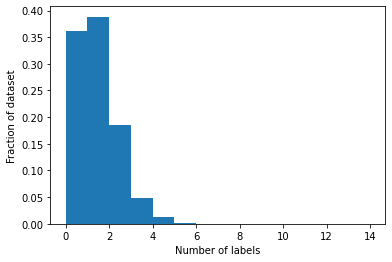

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

def plot_label_frequency(L):
    plt.hist((L != ABSTAIN).sum(axis=1), density=True, bins=range(L.shape[1]))
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")
    plt.show()


plot_label_frequency(L_train)

Our next step is to build a generative model based on the LFs. In order to do so, we convert the labels from our LFs into a single column which has noise-aware probablistic model per data point. We can use `MajorityLabelVoter` model that takes a simple majority vote to determine the label for a data point.


In [ ]:
from snorkel.labeling.model import MajorityLabelVoter

majority_model = MajorityLabelVoter()
preds_train = majority_model.predict(L=L_train)

However, the LFs have varying properties and cannot be treated identically. LFs can be correlated that might results in certain signals being over represented using majority-vote model.

Hence, we use `LabelModel` to produce a single set of noise-aware lables, which are probabilistic or confidence-weighted labels.

In [ ]:
from snorkel.labeling.model import LabelModel
label_model = LabelModel(cardinality=2,verbose=True) # cardinality is number of classes 2
label_model.fit(L_train,n_epochs=1000, log_freq=100,seed=3)

In [ ]:
majority_acc = majority_model.score(L=L_test, Y=Y_test, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_test, Y=Y_test, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   77.0%
Label Model Accuracy:     75.9%


In [ ]:
probs_train = label_model.predict_proba(L=L_train)
probs_train

array([[5.03393836e-01, 4.96606164e-01],
       [2.96629706e-01, 7.03370294e-01],
       [5.00000000e-01, 5.00000000e-01],
       ...,
       [9.99801184e-01, 1.98816027e-04],
       [5.61574910e-01, 4.38425090e-01],
       [2.55167578e-01, 7.44832422e-01]])

## Building a discriminator model

Now, we have a generative model based on the LFs. However, these models will abstain on the data points our labeling functions don't cover. In the next step, we will use the outputs of the `LabelModel` as training labels to train a discriminative model which can generalize beyond the noisy LFs. This classifier will also only need the text of the comment to make predictions, making it much more suitable for inference over unseen comments


Checking that the labels the LabelModel produces are probabilistic. The following histogram shows the confidences we have that each data point has the label SPAM.

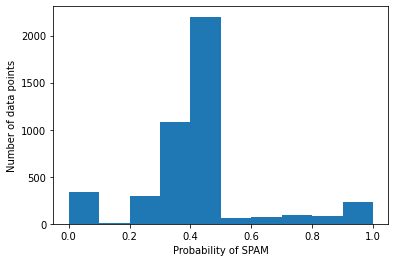

In [ ]:
def plot_probabilities_histogram(Y):
  plt.hist(Y,bins=10)
  plt.xlabel("Probability of SPAM")
  plt.ylabel("Number of data points")
  plt.show()

plot_probabilities_histogram(probs_train[:,1])

**Filtering out unlabeled data points**

As we saw earlier, some of the data points in our train set received no labels from any of our LFs. These data points convey no supervision signal and tend to hurt performance, so we filter them out before training using a built-in utility.

In [ ]:
from snorkel.labeling import filter_unlabeled_dataframe

df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=df_train, y=probs_train, L=L_train
)

In [ ]:
probs_train.shape

(4457, 2)

In [ ]:
print(f"{'train filtered:':<20}{df_train_filtered.shape}")
print(f"{'prob filtered:':<20}{probs_train_filtered.shape}")

train filtered:     (2845, 2)
prob filtered:      (2845, 2)


**Training a Classifier**

In this step, the output of the `LabelModel` is used to train a classifier. The discriminative model learns feature representation of our labeling functions and this makes it better able to generalize to unseen data.

Featurization 

Here, we use a simple "bag of n-grams" feature representation: each data point is represented by a one-hot vector marking which words or 2-word combinations are present in the comment text.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 5))
X_train = vectorizer.fit_transform(df_train_filtered.text.tolist())
X_test = vectorizer.transform(df_test.text.tolist())

In [ ]:
X_train.shape

(2845, 119780)

**Logisitic Regression Classifier**

First,  we replace each label distribution with the label of the class that has the maximum probability using helper function `probs_to_pred`

In [ ]:
from snorkel.utils import probs_to_preds

preds_train_filtered = probs_to_preds(probs=probs_train_filtered)

We use these labels to train our classifier.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

sklearn_model = LogisticRegression(C=1e3, solver="liblinear")
sklearn_model.fit(X=X_train, y=preds_train_filtered)

LogisticRegression(C=1000.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# checking accuracy
print(f"Test Accuracy: {sklearn_model.score(X=X_test, y=Y_test) * 100:.1f}%")

Test Accuracy: 94.9%


Text(0, 0.5, 'True Positive Rate')

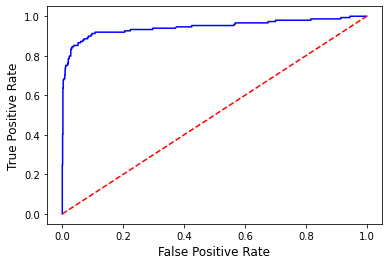

In [ ]:
from sklearn import metrics

#predicted probablities for label 1
y_pred_prob = sklearn_model.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = metrics.roc_curve(Y_test,y_pred_prob,pos_label=1)
plt.plot(fpr, tpr, 'b')
plt.plot([0,1],[0,1], 'r--')
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)

In [ ]:
metrics.auc(fpr, tpr)

0.9458050217460783

We get a higher accuracy using a Discriminator model over `LabelModel`. This is in part because the discriminative model generalizes beyond the noisy labeling function labels and makes good predictions on all data points, not just the ones covered by the labeling functions. 

Now, we look at the precision and recall metrics to better understand the model performance.

In [ ]:
# storing predicted binary values by the model
pred = sklearn_model.predict(X_test)

In [ ]:
# check classiification metrics
print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       966
           1       0.97      0.64      0.77       149

    accuracy                           0.95      1115
   macro avg       0.96      0.82      0.87      1115
weighted avg       0.95      0.95      0.94      1115



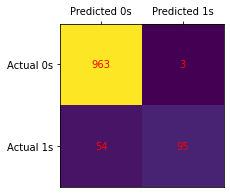

In [ ]:
# plot the confusion matrix
cm = confusion_matrix(Y_test, pred)

plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)

for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()


By looking at the classification matrix, we see that model has a good precision which is good in a way as it is labelling the very minimal HAM messages as SPAM. However, the recall is a bit low which suggests that there is scope for improvement in model performance.

- The first approach could be hypertuning the model parameters. Selecting only those words/tokens the occur most frequently while tokenizing the data. Changing the default regularization and norm pararmeters in the logistic regression model.

- The second approach would be to use more complex deep learning models but that might require more data points as these models are data hungry.

## References:

1. https://github.com/snorkel-team/snorkel-tutorials/blob/master/spam/01_spam_tutorial.ipynb

2. https://www.snorkel.org/blog/weak-supervision

3. https://medium.com/@annalara/understanding-snorkel-5e33351aa43b